# Workflow 2 - reduce the dimensionality of the featurized trajectory

**Input:** EnGen object with the featurized trajectory (generated by Workflow1)


**Output:** Trajectory with rediced dimensionality
<hr>
Steps:

1. Import the featurized trajectory from Workflow1
2. Choose dimensionality reduction technique: <a href=https://github.com/hsidky/srv>HDE</a>, <a href=http://www.emma-project.org/latest/tutorials/notebooks/00-pentapeptide-showcase.html#Coordinate-transform-and-discretization-%E2%9E%9C-%F0%9F%93%93>TICA </a> (PCA)
3. Choose appropriate lag time
    (when using a VAC based approach (HDA or TICA) it is neccessary to choose a lag time appropriately)
4. Visualize the results
5. Save results for Workflow3

In [1]:
#required imports

from engens.core.EnGens import EnGen
from engens.core.DimReduction import *
import pickle as pk
import mdtraj
import numpy as np
import matplotlib.pyplot as plt

plt.ioff() 

### Step 0 - Load the results from Workflow1


In [2]:
engen = None
with open("wf1_resulting_EnGen.pickle", "rb") as file:
    engen = pk.load(file)

Inspect the results from Workflow1 - if any value here is None you might have to run the Workflow1 again.

In [3]:
traj = engen.traj
ref = engen.ref
print("Using the trajectory {} and reference pdb file {}".format(traj, ref))

topology = engen.mdtrajref
print("The topology is:")
print(topology)

frame_num = engen.data[engen.chosen_feat_index][1].shape[0]
print("Number of frames is {}".format(frame_num))

feat_dims = engen.data[engen.chosen_feat_index][1].shape[1]
print("The dimensionality of your featurization is {}".format(feat_dims))

feat = engen.featurizers[engen.chosen_feat_index]
print("You chose to featurize with: "+engen.featurizer_names[engen.chosen_feat_index])
print(feat.describe())

Using the trajectory ./pentapeptide-00-500ns-impl-solv.xtc and reference pdb file ./pentapeptide-impl-solv.pdb
The topology is:
<mdtraj.Topology with 1 chains, 5 residues, 94 atoms, 95 bonds>
Number of frames is 5001
The dimensionality of your featurization is 282
You chose to featurize with: all
['ATOM:TRP 1 N 0 x', 'ATOM:TRP 1 N 0 y', 'ATOM:TRP 1 N 0 z', 'ATOM:TRP 1 H 1 x', 'ATOM:TRP 1 H 1 y', 'ATOM:TRP 1 H 1 z', 'ATOM:TRP 1 H2 2 x', 'ATOM:TRP 1 H2 2 y', 'ATOM:TRP 1 H2 2 z', 'ATOM:TRP 1 CA 3 x', 'ATOM:TRP 1 CA 3 y', 'ATOM:TRP 1 CA 3 z', 'ATOM:TRP 1 HA 4 x', 'ATOM:TRP 1 HA 4 y', 'ATOM:TRP 1 HA 4 z', 'ATOM:TRP 1 CB 5 x', 'ATOM:TRP 1 CB 5 y', 'ATOM:TRP 1 CB 5 z', 'ATOM:TRP 1 HB3 6 x', 'ATOM:TRP 1 HB3 6 y', 'ATOM:TRP 1 HB3 6 z', 'ATOM:TRP 1 HB2 7 x', 'ATOM:TRP 1 HB2 7 y', 'ATOM:TRP 1 HB2 7 z', 'ATOM:TRP 1 CG 8 x', 'ATOM:TRP 1 CG 8 y', 'ATOM:TRP 1 CG 8 z', 'ATOM:TRP 1 CD1 9 x', 'ATOM:TRP 1 CD1 9 y', 'ATOM:TRP 1 CD1 9 z', 'ATOM:TRP 1 HD1 10 x', 'ATOM:TRP 1 HD1 10 y', 'ATOM:TRP 1 HD1 10 z',

### Step 1 - Choose the method for dimensionality reduction and apply it


Transforming with TICA - might take some time!
lag: 1
lag: 8
lag: 15
lag: 22
lag: 29
lag: 36
lag: 43
lag: 50
lag: 57
lag: 64
lag: 71
lag: 78
lag: 85
lag: 92
lag: 100
Number of resolved processes with TICA: 1
Processes (index, timescale): 
[(0, 183.8003359173391)]
Chosen lag time: 29


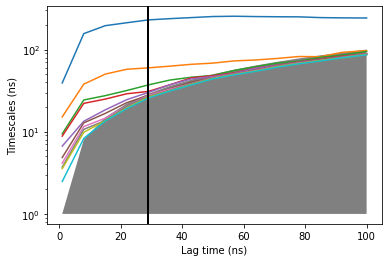

TICA explained variance (with thr = 80) by first 99 components
Total of 80.1384577555041% of variance explaned by first 99 ICs.


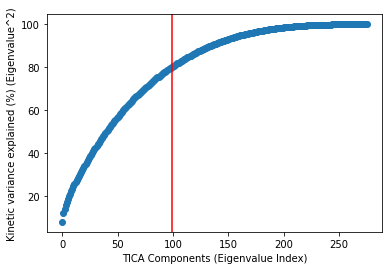

'\n#choose HDE\nreduction_type = "HDE" \n#find best lag range for your data\ntraj_times = mdtraj.load(engen.traj, top=engen.ref).time\ntraj_nframes = len(traj_times)\nlags = [int(np.log(i)) for i in np.logspace(1, int(traj_nframes/50), num=15, base=np.e)]\n#find best output dimensionality for your data\nfeat_dims = engen.data[engen.chosen_feat_index][1].shape[1]\n# min(50, 10% of the feature dimensions)\noutput_dims = min(50, int(feat_dims*0.1))\n#initialize HDE reducer\nreducer = dimreds[reduction_type](engen, lags, output_dims)\n#estimate number of resolved processes and choose the lag time automatically\nlag = reducer.choose_lag_auto()\n#visualize HDE resolved process scales with different lags\nreducer.plot_lag_analysis(chosen_lag=lag)\nplt.show()\n'

In [11]:
# Here you will perform dimensionality reduction 

# ------------------there are three options--------------------- #
# -------------------PCA, TICA or HDE----------------------------#
# --------- --uncomment the one you want to try------------------#

#Option 1 - PCA (not recommended)
'''
#chose PCA 
reduction_type = "PCA" 
reducer = dimreds[reduction_type](engen)
#choose the variance theshold you want to explain and pick number of components
var_thr = 80
reducer.plot_variance(var_thr)
plt.show()
n_components = reducer.get_variance(var_thr)
#select the given number of components
reducer.choose_n(n_components)
'''

#Option 2 - TICA 


#chose TICA 
reduction_type = "TICA" 
#to make an informed decision on lag time range see the timescale of your simulation
traj_times = mdtraj.load(engen.traj, top=engen.ref).time
traj_nframes = len(traj_times)
lags = [int(np.log(i)) for i in np.logspace(1, int(traj_nframes/50), num=15, base=np.e)]
#initialize TICA reducer
reducer = dimreds[reduction_type](engen, lags)
#estimate number of resolved processes and choose the lag time automatically
lag = reducer.choose_lag_auto()
#visualize TICA resolved process scales with different lags
reducer.plot_lag_analysis(chosen_lag=lag)
plt.show()
#choose variance threshold and number of components
var_thr = 80
n_components = reducer.get_variance(var_thr=var_thr)
reducer.plot_variance(var_thr=var_thr)
plt.show()
#select the corresponding number of components
reducer.choose_n(n_components)


#Option 3 - HDE 

'''
#choose HDE
reduction_type = "HDE" 
#find best lag range for your data
traj_times = mdtraj.load(engen.traj, top=engen.ref).time
traj_nframes = len(traj_times)
lags = [int(np.log(i)) for i in np.logspace(1, int(traj_nframes/50), num=15, base=np.e)]
#find best output dimensionality for your data
feat_dims = engen.data[engen.chosen_feat_index][1].shape[1]
# min(50, 10% of the feature dimensions)
output_dims = min(50, int(feat_dims*0.1))
#initialize HDE reducer
reducer = dimreds[reduction_type](engen, lags, output_dims)
#estimate number of resolved processes and choose the lag time automatically
lag = reducer.choose_lag_auto()
#visualize HDE resolved process scales with different lags
reducer.plot_lag_analysis(chosen_lag=lag)
plt.show()
'''

### Step 2 - inspect the results visually

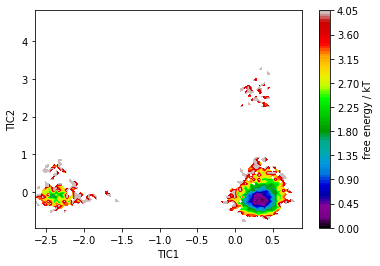

In [12]:
reducer.plot_2d()
plt.show()

In [13]:
reducer.plot_3d()

### Step 3 - save results for Workflow3 and clustering

In [15]:
# to apply the dimensionality reduction to the engen structure run:
reducer.apply()

# to save the results from this analysis for workflow3 run:
with open("wf2_resulting_EnGen.pickle", "wb") as file:
    pk.dump(engen, file, -1)
with open("wf2_resulting_Reducer.pickle", "wb") as file:
    pk.dump(reducer, file, -1)